In [12]:
pip install wordcloud

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
pip install gensim

# **Import**

In [15]:
import pandas as pd
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [16]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [17]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_fix.csv')
dataset.head()

Unnamed: 0                       id_review  \
0           0  0AV0mU6Ah4sD7RW2nv0oq6Di3Xk1Xc   
1           1  0De9jM9LB3gz7jp0Uo2Wm5oO0cJ3Gn   
2           2  0EZ7BP9hm1uE7CO9cV7gJ8XX8Fs4aD   
3           3  0Hd8XX7Ag5SZ6OA2PE9Wj1bh8FD5tG   
4           4  0Hi1ad3Jw4ui8gm0Th1xT1EP8Um7xj   

                                  review_clean_cased  \
0  Pernah kesini waktu SD dulu lokasi nya real ma...   
1  Disini pas banget buat piknik bareng keluarga ...   
2  Sudah beberapa kali ke Candi Borobudur Tempatn...   
3  Salah satu tujuan utama ke Yogyakarta adalah k...   
4  Waktu yang tepat untuk mengunjungi borobudur a...   

                                  review_low_uncased  \
0  pernah kesini waktu sd dulu lokasi nya real ma...   
1  disini pas banget buat piknik bareng keluarga ...   
2  sudah beberapa kali ke candi borobudur tempatn...   
3  salah satu tujuan utama ke yogyakarta adalah k...   
4  waktu yang tepat untuk mengunjungi borobudur a...   

                                              review  attractions  amenities  \
0  Pernah kesini waktu SD dulu lokasi nya real ma...            3          0   
1  Disini pas banget buat piknik bareng keluarga ...            3          0   
2  Sudah beberapa kali ke Candi Borobudur. Tempat...            3          3   
3  Salah satu tujuan utama ke Yogyakarta adalah k...            3          0   
4  Waktu yang tepat untuk mengunjungi borobudur a...            0          3   

   access  price  no_aspect  \
0       0      0          3   
1       0      0          3   
2       0      0          0   
3       3      0          2   
4       0      0          2   

                                    attractions_text  \
0  pernah kesini waktu sd dulu lokasi nya real ma...   
1  tempatnya sejuk dan sangat nyaman tempatnya se...   
2  tempatnya bersih terpeihara dilihat dari area ...   
3  tempat yang indah dan menakjubkan salah satu t...   
4                                               none   

                                      amenities_text  \
0                                               none   
1                                               none   
2  tempatnya bersih terpeihara dilihat dari area ...   
3                                               none   
4  waktu yang tepat untuk mengunjungi borobudur a...   

                                         access_text price_text  \
0                                               none       none   
1                                               none       none   
2                                               none       none   
3  sedia ojek payung agar tidak kepanasan sedia o...       none   
4                                               none       none   

                                      no_aspect_text  
0  boleh dicoba tuh kawan boleh dicoba tuh kawan ...  
1  disini pas banget buat piknik bareng keluarga ...  
2                                               none  
3  salah satu tujuan utama ke yogyakarta adalah k...  
4  waktu yang tepat untuk mengunjungi borobudur a...

# **Aspek Amenities**



```
# This is formatted as code
```

### **Text Negatif**

In [18]:
# bukan "none" dan mengambil "negative"
df_amenities = dataset[(dataset['amenities'] != 0) & ((dataset['amenities'] == 1))]
df_amenities_negative = df_amenities[['amenities_text']].values

custom_stop_words = ['yang', 'di', 'dan', 'untuk', 'juga', 'ada', 'dari', 'anda', 'ke', 'sudah',
                     'ke', 'sangat', 'ini', 'yg', 'bisa', 'banyak', 'atau', 'dengan', 'lebih', 'kita', 'saya',
                     'tidak', 'salah', 'satu', 'hanya', 'akan', 'dapat', 'karena', 'adalah', 'jadi', 'nya', 'sdh', 'msh']

def elim_stopword(text):
    tokens = text.split(" ")
    filtered_tokens = [token for token in tokens if token.lower() not in custom_stop_words]
    joined_text = " ".join(filtered_tokens)

    return joined_text

df_amenities['amenities_text'] = df_amenities['amenities_text'].apply(lambda x: elim_stopword(x))

teks_negatif = df_amenities['amenities_text']
print(teks_negatif)
# df_amenities_negative.head()

15      tiket masuk lbh tertib harga karcis terjangkau...
37      tempat wisata bagus kabupaten magelang tapi sa...
49      memang terdapat kekurangan pada banyaknya peda...
71      disana memiliki fountain drinking water memili...
102     kepala stupa hilang dicuri sehingga lambat lau...
                              ...                        
1607    tempat bersejarah penuh kekaguman luar biasa s...
1615    sedang renovasi sehingga agak kurang nyaman na...
1617    tapi disayangkan kepala budha hilang jika nant...
1620    dalam lokasi wisata kafe terus klo mau beli ol...
1625    kalo jalanan bawah sekitaran candi plester bat...
Name: amenities_text, Length: 178, dtype: object


<ipython-input-18-e122b37b0f87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amenities['amenities_text'] = df_amenities['amenities_text'].apply(lambda x: elim_stopword(x))


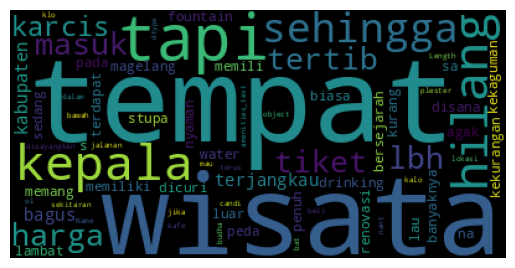

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

wordcloud = WordCloud().generate(str(teks_negatif))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **LDA Topic Modelling**

In [20]:
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens
tokens_negatif = [tokenisasi(t) for t in teks_negatif]
print(tokens_negatif)

[['tiket', 'masuk', 'lbh', 'tertib', 'harga', 'karcis', 'terjangkau', 'toilet', 'tersedia', 'agak', 'kurang', 'bersih', 'candi', 'megah', 'telah', 'dilengkapi', 'tangga', 'tambahan', 'berupa', 'bantalan', 'kayu', 'pegangan', 'tangga', 'sehingga', 'memudahkan', 'pengunjung', 'menaikinya', 'toilet', 'tersedia', 'agak', 'kurang', 'bersih', 'tiket', 'masuk', 'lbh', 'tertib', 'harga', 'karcis', 'terjangkau', 'toilet', 'tersedia', 'agak', 'kurang', 'bersih'], ['tempat', 'wisata', 'bagus', 'kabupaten', 'magelang', 'tapi', 'sayang', 'harga', 'tiket', 'domestik', 'masih', 'cukup', 'mahal', 'wisatawan', 'rp', 'sebanding', 'fasilitas', 'penataan'], ['memang', 'terdapat', 'kekurangan', 'pada', 'banyaknya', 'pedagang', 'menawarkan', 'barang', 'cukup', 'memaksa', 'namun', 'itu', 'semua', 'berarti', 'setelah', 'melihat', 'tempatnya', 'memang', 'terdapat', 'kekurangan', 'pada', 'banyaknya', 'pedagang', 'menawarkan', 'barang', 'cukup', 'memaksa', 'namun', 'itu', 'semua', 'berarti', 'setelah', 'melihat'

In [21]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(tokens_negatif)
# Create Corpus
# Term Frequency
corpus = [id2word.doc2bow(text) for text in tokens_negatif]
# View
print(id2word)
print(corpus[:1])

Dictionary<1386 unique tokens: ['agak', 'bantalan', 'bersih', 'berupa', 'candi']...>
[[(0, 3), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 3), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 3), (23, 2), (24, 2), (25, 3)]]


In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('agak', 3),
  ('bantalan', 1),
  ('bersih', 3),
  ('berupa', 1),
  ('candi', 1),
  ('dilengkapi', 1),
  ('harga', 2),
  ('karcis', 2),
  ('kayu', 1),
  ('kurang', 3),
  ('lbh', 2),
  ('masuk', 2),
  ('megah', 1),
  ('memudahkan', 1),
  ('menaikinya', 1),
  ('pegangan', 1),
  ('pengunjung', 1),
  ('sehingga', 1),
  ('tambahan', 1),
  ('tangga', 2),
  ('telah', 1),
  ('terjangkau', 2),
  ('tersedia', 3),
  ('tertib', 2),
  ('tiket', 2),
  ('toilet', 3)]]

In [23]:
# Build LDA model
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=3,random_state=100,chunksize=100,passes=10,per_word_topics=True)

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=100,chunksize=100,passes=10,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

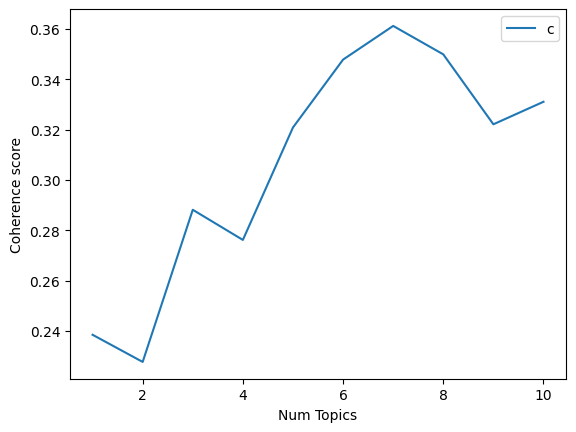

coherence_values:  [0.2384962899751692, 0.22771470251329898, 0.28813362953503613, 0.27616140287004054, 0.3208181630935922, 0.3477716127421302, 0.3611436043785897, 0.34985019796298505, 0.3220776759521499, 0.3310211084838503]


In [25]:
start=1
limit=11
step=1
model_list, coherence_values = compute_coherence_values(id2word, corpus, tokens_negatif, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
print("coherence_values: ", coherence_values)

In [26]:
lda_model.print_topics() #num_word default is 10

[(0,
  '0.015*"jauh" + 0.014*"pedagang" + 0.012*"lagi" + 0.012*"pengunjung" + 0.011*"keluar" + 0.010*"candi" + 0.009*"sampai" + 0.009*"pasar" + 0.009*"masuk" + 0.009*"parkiran"'),
 (1,
  '0.013*"parkir" + 0.013*"tiket" + 0.012*"masuk" + 0.011*"oleh" + 0.011*"tempat" + 0.011*"candi" + 0.011*"mau" + 0.010*"pedagang" + 0.010*"kurang" + 0.009*"area"'),
 (2,
  '0.026*"naik" + 0.025*"candi" + 0.013*"kurang" + 0.012*"harus" + 0.012*"borobudur" + 0.012*"atas" + 0.011*"tapi" + 0.010*"agak" + 0.009*"toilet" + 0.008*"tempat"')]

In [27]:
print("Topic distribution for document :", " ".join(tokens_negatif[0]))
print("feature of each token:", [(id2word[id], freq) for id, freq in corpus[0]])
lda_model.get_document_topics(corpus[0])

Topic distribution for document : tiket masuk lbh tertib harga karcis terjangkau toilet tersedia agak kurang bersih candi megah telah dilengkapi tangga tambahan berupa bantalan kayu pegangan tangga sehingga memudahkan pengunjung menaikinya toilet tersedia agak kurang bersih tiket masuk lbh tertib harga karcis terjangkau toilet tersedia agak kurang bersih
feature of each token: [('agak', 3), ('bantalan', 1), ('bersih', 3), ('berupa', 1), ('candi', 1), ('dilengkapi', 1), ('harga', 2), ('karcis', 2), ('kayu', 1), ('kurang', 3), ('lbh', 2), ('masuk', 2), ('megah', 1), ('memudahkan', 1), ('menaikinya', 1), ('pegangan', 1), ('pengunjung', 1), ('sehingga', 1), ('tambahan', 1), ('tangga', 2), ('telah', 1), ('terjangkau', 2), ('tersedia', 3), ('tertib', 2), ('tiket', 2), ('toilet', 3)]


[(2, 0.98331696)]

In [28]:
import pandas as pd
def format_topics_sentences(ldamodel, corpus, texts):
      # Init output
      sent_topics_df = pd.DataFrame()

      # Get main topic in each document
      for i, row in enumerate(ldamodel[corpus]):
          row = sorted(row[0], key=lambda x: (x[1]), reverse=True)

          # Get the Dominant topic, Perc Contribution and Keywords for each document
          for j, (topic_num, prop_topic) in enumerate(row):
              if j == 0: # => dominant topic
                   wp = ldamodel.show_topic(topic_num, 5) #get most  significant topic
                   topic_keywords = ", ".join([word for word, prop in wp])
                   sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
              else:
                   break
      sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

      # Add original text to the end of the output
      contents = pd.Series(texts)
      sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
      return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tokens_negatif)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic Keywords', 'Text']

#Save to csv
df_dominant_topic.to_csv('/content/drive/MyDrive/Colab Notebooks/doc_topic_dominant_amenities_negative.csv')
# Show
df_dominant_topic.head(5)

<ipython-input-28-25286c550ff5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-28-25286c550ff5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-28-25286c550ff5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-28-25286c550ff5>:15: FutureWarning: The frame.append method is deprecated and will be removed from p

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               2              0.9833   
1            1               1              0.6490   
2            2               0              0.9863   
3            3               0              0.8586   
4            4               2              0.9759   

                             Topic Keywords  \
0     naik, candi, kurang, harus, borobudur   
1        parkir, tiket, masuk, oleh, tempat   
2  jauh, pedagang, lagi, pengunjung, keluar   
3  jauh, pedagang, lagi, pengunjung, keluar   
4     naik, candi, kurang, harus, borobudur   

                                                Text  
0  [tiket, masuk, lbh, tertib, harga, karcis, ter...  
1  [tempat, wisata, bagus, kabupaten, magelang, t...  
2  [memang, terdapat, kekurangan, pada, banyaknya...  
3  [disana, memiliki, fountain, drinking, water, ...  
4  [kepala, stupa, hilang, dicuri, sehingga, lamb...

In [29]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
texts=tokens_negatif, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.28813362953503613


In [30]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Per Topic Score: ', coherence_per_topic)


Coherence Per Topic Score:  [0.34457185791139616, 0.22486658376302998, 0.2949624469306823]


In [31]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn

In [32]:
pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [33]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
# Visualize the topics

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.110780  0.104560       1        1  39.225936
2     -0.160408  0.030442       2        1  31.520813
1      0.049628 -0.135002       3        1  29.253251, topic_info=         Term        Freq       Total Category  logprob  loglift
243      naik  113.000000  113.000000  Default  30.0000  30.0000
163    parkir   68.000000   68.000000  Default  29.0000  29.0000
53   pedagang   82.000000   82.000000  Default  28.0000  28.0000
145      oleh   57.000000   57.000000  Default  27.0000  27.0000
25     toilet   44.000000   44.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
25     toilet   16.622993   44.587395   Topic3  -5.1630   0.2425
940      tayo   14.433997   34.232814   Topic3  -5.3042   0.3656
590     bayar   13.108462   28.585346   Topic3  -5.4006   0.4495
72     keluar   13.682363   60.682146   Topic3  -5.3577  -0.2604
45        itu   13.388753   51.047193   Topic3  -5.3794  -0.1092

[225 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.162589   agak
0         2  0.609708   agak
0         3  0.223560   agak
58        1  0.044385    air
58        2  0.044385    air
...     ...       ...    ...
1072      2  0.914488  worth
963       3  0.882438  wudhu
147       1  0.042560     ya
147       2  0.297920     ya
147       3  0.680960     ya

[304 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])